# サンプルデータの読み込み

In [ ]:
!git clone https://github.com/ARIM-Training/SEM_ZEISS_SUPRA40.git
%cd SEM_ZEISS_SUPRA40

# サンプルデータの確認

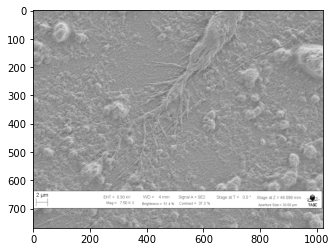

In [1]:
#iライブラリ
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from tqdm import tqdm

DATADIR = "data"

#分類アノテーションをフォルダ名とする
CATEGORIES = ["Biological", "Fibres", 
              "Films_Coated_Surface","MEMS_devices_and_electrodes",
              "Nanowires", "Particles", 
              "Patterned_surface", "Porous_Sponge",
              "Powder", "Tips" ]

#画像ファイルのチェック
for category in CATEGORIES: 
    path = os.path.join(DATADIR,category)  
    for img in os.listdir(path): 
        img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE) 
        plt.imshow(img_array, cmap='gray') 
        plt.show()  

        break  
    break

In [2]:
#サイズ
print(img_array.shape) 

(768, 1024)


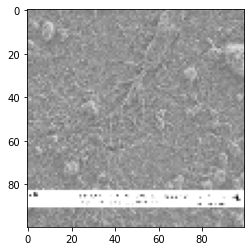

In [3]:
#画像サイズの変更

IMG_SIZE = 100 

new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
plt.imshow(new_array, cmap='gray')
plt.show()

# 訓練データの作成

In [ ]:
training_data = []
 
def create_training_data():
    for category in CATEGORIES:
 
        path = os.path.join(DATADIR,category)  
        class_num = CATEGORIES.index(category) 
 
        for img in tqdm(os.listdir(path)): 
        
            try:
                img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)  
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  
                training_data.append([new_array, class_num]) 
                
            except Exception as e: 
                pass

create_training_data()

# ラベルデータの作成

In [ ]:
X = []
y = []

for features,label in training_data:
    X.append(features)
    y.append(label)

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)

# 訓練データのpickleパッケージ化

In [ ]:
import pickle

pickle_out = open("data/X.pickle","wb")
pickle.dump(X, pickle_out)
pickle_out.close()

pickle_out = open("data/y.pickle","wb")
pickle.dump(y, pickle_out)
pickle_out.close()

# CNNモデル訓練

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

from tensorflow.keras.callbacks import TensorBoard
import pickle
import time
import numpy as np

NAME = "Sem-image-data-CNN-v2"

pickle_in = open("data/X.pickle","rb")
X = pickle.load(pickle_in)

pickle_in = open("data/y.pickle","rb")
y = pickle.load(pickle_in)
y = np.array(y)

X = X/255.0

# CNNモデル
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=X.shape[1:]))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(10))
model.summary()

tensorboard = TensorBoard(log_dir="data/logs/{}".format(NAME))


model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy']
             )

history = model.fit(X, y, 
                    epochs=20, 
                    validation_split=0.2, 
                    callbacks=[tensorboard]
                   )

# 精度検証

In [ ]:
import matplotlib.pyplot as plt

def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


plot_hist(history)

# Tensorボードでの可視化

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
%tensorboard --logdir 'data/logs'

# モデルの高度化

In [ ]:
#ライブラリ
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

from tensorflow.keras.callbacks import TensorBoard
import pickle
import time
import numpy as np

#ファイルの読み込み
pickle_in = open("data/X.pickle","rb")
X = pickle.load(pickle_in)

pickle_in = open("data/y.pickle","rb")
y = pickle.load(pickle_in)
y = np.array(y)

X = X/255.0

dense_layers = [0]
layer_sizes = [64]
conv_layers = [1,2,3]

for dense_layer in dense_layers:
    for layer_size in layer_sizes:
        for conv_layer in conv_layers:
            NAME = "{}-conv-{}-nodes-{}-dense-{}".format(conv_layer, layer_size, dense_layer, int(time.time()))
            print(NAME)

            model = Sequential()

            model.add(Conv2D(layer_size, (3, 3), input_shape=X.shape[1:]))
            model.add(Activation('relu'))
            model.add(MaxPooling2D(pool_size=(2, 2)))

            for l in range(conv_layer-1):
                model.add(Conv2D(layer_size, (3, 3)))
                model.add(Activation('relu'))
                model.add(MaxPooling2D(pool_size=(2, 2)))

            model.add(Flatten())

            for _ in range(dense_layer):
                model.add(Dense(layer_size))
                model.add(Activation('relu'))

            model.add(Dense(10))
            model.add(Activation('softmax'))

            tensorboard = TensorBoard(log_dir="data/logs-v4-change-convo/{}".format(NAME))

            model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                          optimizer='adam',
                          metrics=['accuracy'],
                          )

            model.fit(X, y,
                      batch_size=32,
                      epochs=10,
                      validation_split=0.2,
                      callbacks=[tensorboard])

# Tensorボードでの可視化

In [ ]:
%load_ext tensorboard
%tensorboard --logdir 'data/logs-v4-change-convo'

# 最適化

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
import pickle
import time
import numpy as np

pickle_in = open("data/X.pickle","rb")
X = pickle.load(pickle_in)

pickle_in = open("data/y.pickle","rb")
y = pickle.load(pickle_in)
y = np.array(y)

X = X/255.0

dense_layers = [0]
layer_sizes = [256]
conv_layers = [1]

for dense_layer in dense_layers:
    for layer_size in layer_sizes:
        for conv_layer in conv_layers:
            NAME = "{}-conv-{}-nodes-{}-dense-{}".format(conv_layer, layer_size, dense_layer, int(time.time()))
            print(NAME)

            model = Sequential()

            model.add(Conv2D(layer_size, (3, 3), input_shape=X.shape[1:]))
            model.add(Activation('relu'))
            model.add(MaxPooling2D(pool_size=(2, 2)))

            for l in range(conv_layer-1):
                model.add(Conv2D(layer_size, (3, 3)))
                model.add(Activation('relu'))
                model.add(MaxPooling2D(pool_size=(2, 2)))

            model.add(Flatten())

            for _ in range(dense_layer):
                model.add(Dense(layer_size))
                model.add(Activation('relu'))

            model.add(Dense(10))
            model.add(Activation('softmax'))

            tensorboard = TensorBoard(log_dir="data/logs-64x2x0/{}".format(NAME))

            model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                          optimizer='adam',
                          metrics=['accuracy'],
                          )

            model.fit(X, y,
                      batch_size=32,
                      epochs=50,
                      validation_split=0.2,
                      callbacks=[tensorboard])
model.save('data/64x2-CNN.model')

# Tensorボードでの可視化

In [ ]:
%load_ext tensorboard
%tensorboard --logdir 'data/logs-64x2x0'

In [ ]:
!pwd
%cd data

In [ ]:

from google.colab import files

files.download("64x2-CNN.model")

# 予測検証

In [ ]:
import cv2
import tensorflow as tf

#分類ラベリング
CATEGORIES = ["Biological", 
              "Fibres", 
              "Films_Coated_Surface",
              "MEMS_devices_and_electrodes", 
              "Nanowires", 
              "Particles", 
              "Patterned_surface", 
              "Porous_Sponge", 
              "Powder", 
              "Tips" ]



def prepare(filepath):
    IMG_SIZE = 100  # 50 in txt-based
    img_array = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    return new_array.reshape(-1, IMG_SIZE, IMG_SIZE, 1)


model = tf.keras.models.load_model("data/64x2-CNN.model")

prediction = model.predict([prepare('data/prediction_data/biology.jpg')])
print(prediction)  # will be a list in a list.
print(CATEGORIES[int(max(prediction[0]))])

prediction = model.predict([prepare('data/prediction_data/fiber.jpg')])
print(prediction)  # will be a list in a list.
print(CATEGORIES[int(max(prediction[0]))])
prediction